<center>
<h2>Online learning platform database - MySQL</h2>
</center>

<h3>Preliminary operations: import csv files into MySQL (<code>LOAD DATA</code> statement)</h3>

<h4>Core syntax</h4><br>
Import of a csv file in MySQL can be performed by a <code>LOAD DATA</code> statement. The file to be imported must be specified after the <code>INFILE</code> keyword, while the table name where the data will be copied must be specified after the <code>INTO TABLE</code> keywords. So, the basic structure of a <code>LOAD DATA</code> statement is as follows:
<br>
<code>
    LOAD DATA
    INFILE '<i>mycsvfile.csv</i>'
    INTO TABLE <i>mytable</i>
</code>
<br>
<h4>Optional clauses</h4><br>
- <code>FIELDS</code> and <code>LINES</code><br>
It is also useful to include some optional keywords in the statement, providing the DBMS information on how the data is organised into the csv file. These may refer to <code>FIELDS</code> (<code>TERMINATED BY</code> and <code>ENCLOSED BY</code>) or <code>LINES</code> (<code>TERMINATED BY</code>) and are used to tell the DBMS, in order:

 - how fields (columns, attributes) are separated by one another (by commas '<i>,</i>' in the following case);
 - that characters within double quotes must not be considered as separators ('<i>"</i>'). Since the data contained in each field are not necessarily enclosed within double quotes (they usually are when there is a comma that does not separate fields), the keyword <code>OPTIONALLY</code> is also used;
 - to perform a new insertion (insert a new row) when meeting the special character indicating a new line ('<i>\n</i>'):
<br>
<code>
    LOAD DATA
    INFILE '<i>mycsvfile.csv</i>'
    INTO TABLE <i>mytable</i>
    FIELDS TERMINATED BY ','
    OPTIONALLY ENCLOSED BY '"'
    LINES TERMINATED BY '\n'
</code>
<br>
- <code>IGNORE</code><br>
By specifying to <code>IGNORE 1 ROWS</code> we declare that the first row of the csv file must not be inserted into the table (we imply, usually, that it contains the attribute names of the table).<br>
<br>
- <code>LOCAL</code><br>
Finally, it is to be considered that 'mycsvfile.csv' is expected to be located on the server host. If it is not the case (we want to load a text file located on the client host) the keyword <code>LOCAL</code> must be specified immediately after <code>LOAD DATA</code>.<br> The complete statement to import a csv file into MySQL is then as follows:
<br>
<code>
    LOAD DATA 
    LOCAL INFILE '<i>mycsvfile.csv</i>'
    INTO TABLE <i>mytable</i>
    FIELDS TERMINATED BY ','
    OPTIONALLY ENCLOSED BY '"'
    LINES TERMINATED BY '\n'
    IGNORE 1 ROWS;
</code>
<br>
<h4>A note on the use of <code>LOCAL</code>:</h4><br>
Since there are potential security implications within the process of transferring a file from the client to the server (these are specified <a href = 'https://dev.mysql.com/doc/refman/8.0/en/load-data-local-security.html'>here</a> and consist either in the theoretical possibility for a server to gain access to any part of the file system to which the client has access or in the possibility, in a web environment, that a user connected to the web server is allowed to read any files that the web server has read access to), the use of <code>LOCAL</code> may return an error if the client host and the server host are not configured appropriately.<br>For example, if I run MySQL from a Docker container, select a database and create a table with a schema matching the header of the csv file, I can run and perform the afore mentioned <code>LOAD DATA</code> statement, and be returned the error:<br><code>ERROR 3948 (42000): Loading local data is disabled; this must be enabled on both the client and server sides</code>. For control over local data loading, MySQL permits this capability to be enabled or disabled.

At the <b>server level</b>, the capability is controlled by the global system variable <code>local_infile</code>. So, to check if it is enabled at the server level, a <code>SHOW GLOBAL VARIABLES</code> statement can be performed:
<br>
<code>
    SHOW GLOBAL VARIABLES LIKE 'local_infile'
</code>

This is usually set to <i>OFF</i>, so a <code>SET GLOBAL</code> statement on the aforementioned variable would allow us to change it to <i>ON</i>:
<br>
<code>
    SET GLOBAL local_infile = True
</code>

At the <b>client level</b>, it is sufficient to start MySQL with the option <code>local_infile=1</code> to enable the capability:
<br>
<code>
    mysql --local_infile=1 -uroot -p
</code>
<br>
<h4>Notes when running MySQL from a Docker container:</h4><br>
A couple of further notes are required when running MySQL within a Docker container. Since a Docker container has its own file system, MySQL cannot access parts of the file system not mounted to the container. In particular, the csv file cannot be loaded by MySQL from outside the container. Hence it has to be copied to the container with the <code>docker cp</code> command. This command allows either to copy a file from the container to the local machine or the reverse (which is what we want here). We need to simply pass the source path and file name and the destination path. In our case it would be:
<br>
<code>
    docker cp <i>path/mycsvfile.csv</i> <i>container:/path</i>
</code>

where <i>container</i> is the container name. To put the file in the root folder of the container one can simply type <code><i>container:/</i></code> as destination.

Furthermore, I want to load the csv file from within a SQL script. This script is organised in a <code>CREATE TABLE</code> statement and a <code>LOAD DATA</code> statement (it is advised to also indicate the database where to create the table, or to create it as well). The table creation specifies a schema that matches exactly the first row of the csv file, which contains the table header. The import statement specifies the csv file name and it optionally indicates its path. Actually, I copied the csv files (the four differently sized files) directly into the container, without specifying any container subfolder, hence I would simply indicate the file name in single quotes after the <code>LOCAL INFILE</code> clause of the <code>LOAD DATA</code> statement. Exactly as it is shown in the above templates.

A final consideration regards the execution of an external script from a MySQL instance run from within a container. As the <a href = 'https://hub.docker.com/_/mysql'>MySQL Docker Hub</a> web page points out under the paragraph <i>Restoring data from dump files</i>, MySQL must be executed from the container together with the indication of the script that we want to be executed:
<br>
<code>
    docker exec -i <i>container</i> mysql --local_infile=1 -uroot -p[PASSWORD] &#60; <i>path/myscript.sql</i>
</code>

Notice the use of the option <code>local_infile=1</code> when starting the server to enable file loading at the client level. Previously, after starting the MySQL container, we must have set the <code>local_infile</code> global variable on as previously specified. Also notice that this procedure does not allow us to input the password interactively. It must be provided when running the <code>docker exec</code> command from the command line.

After successful execution of the script we are returned to the system folder from which we have run the <code>docker exec</code> command. By entering MySQL again we can check if the scripted actions have been actually performed on the MySQL server.

<br>
<h4>Recap and summarize:</h4><br>
To recap and summarize, the procedure to import a csv file on MySQL requires us to perform the following actions, in order:

- start the MySQL container;
- copy the csv file into the container (<code>docker cp</code>);
- login to MySQL and set the global variable <code>local_infile</code> to ON;
- logout from MySQL;
- call the SQL script containing the <code>LOAD DATA</code> statement while accessing to the MySQL server with the <code>docker exec</code> command;
- login to MySQL and check if the script execution has obtained the required results.


<h3>Python - MySQL interaction</h3>

Interaction between a Python API and a MySQL server requires the installation of a specific driver. I opt for <i>MySQL Connector/Python</i> which is officially developed and mantained by the MySQL team and requires only the Python standard library to work properly. Documentation of the driver is provided in the web page <a href = 'https://dev.mysql.com/doc/index-connectors.html'>Connectors and APIs</a> of the MySQL web site. This page illustrates MySQL drivers available for a number of programming languages, Python included.<br>After having installed the driver, it can be imported in Python the usual way.

In [1]:
import mysql.connector as connector

<h4>
Establishing a connection to MySQL
</h4><br>
A connection to the MySQL server can be established by creating a <a href ='https://dev.mysql.com/doc/connector-python/en/connector-python-connecting.html'>connection object</a> (stored in a Python variable: <i>conn</i>, in our case) with the <code>connect</code> method of the driver. Host address, (optionally) port, authentication and database name must be passed to the object.<br>Consider that '<i>localhost</i>' could be equivalently used as <code>host</code> name.

In [2]:
conn = connector.connect(host = '127.0.0.1', port = '3306', user = 'root', password = 'X4mPpd3V', database = 'dbB_MYSQL_test')

<h4>
Creating a <i>cursor</i> object
</h4><br>
A <a href = 'https://dev.mysql.com/doc/connector-python/en/connector-python-api-mysqlcursor.html'>cursor object</a> can interact with the MySQL server thanks to the previously defined connection object. The cursor allows us to perform operations such as SQL statements (the cursor properties can be accessed by the function <code>dir()</code>). Once defined, the cursor object keeps the information required to access the MySQL server of our choice.

In [3]:
cursor = conn.cursor()

<h4>
Executing a query
</h4><br>
In our case, after having assigned a SQL statement to the Python variable <i>sql</i>, we call the <code>execute</code> method of the <i>cursor</i> object to perform the defined query. <span style = 'color:rgba(255,50,100,1);'>The query result is stored as a property of the <i>cursor</i> object that can be accessed only after an operation has been actually performed</span>. For example, when we run a <code>SELECT</code> query that returns tuples of the selected attributes, looping over the cursor grants direct access to the entire tuples. Assigning Python variables as tuples grants access to each attribute of the query result. 

In [4]:
sql = 'SELECT DISTINCT firstName, lastName FROM smallDB WHERE courseID = 192'
cursor.execute(sql)

In [5]:
for record in cursor:
    print(record)

('Custodia', 'Hidalgo')
('Sarah', 'Lara')
('Narciso', 'Ferrán')
('Patrícia', 'Leite')
('Vigilija', 'Gaižauskas')
('Casandra', 'Arenas')
('Ledün', 'Soylu')
('Arthur', 'Laroche')
('Ana', 'Narušis')
('Nath', 'Nicolas')
('Émile', 'Nicolas')
('Cathrine', 'Lie')
('Ingeborg', 'Amundsen')


<h4>
Displaying a query result
</h4><br>
We are required to know the schema of the result set of the sql statement: in the example case we know that the output will be a certain (unknown <i>a priori</i>) number of rows over two attributes (fields, columns). So we define two variables that we want to be printed when looping over the cursor object.

In [6]:
sql = 'SELECT DISTINCT firstName, lastName FROM smallDB WHERE courseID = 192'
cursor.execute(sql)
# query result
for name, surname in cursor:
    print(name, surname)

Custodia Hidalgo
Sarah Lara
Narciso Ferrán
Patrícia Leite
Vigilija Gaižauskas
Casandra Arenas
Ledün Soylu
Arthur Laroche
Ana Narušis
Nath Nicolas
Émile Nicolas
Cathrine Lie
Ingeborg Amundsen


Notice that, after having executed the query, the result must be accessed in some way (by looping over the cursor object or fetching the result itself) before running a new query on the same object. Performing the query execution again before freeing up memory would result in an <code>InternalError</code> throwing the message: <i>Unread result found</i>. As a complement of that, after the memory used by the object result is freed, the result cannot be accessed any longer. The result records are stored in the <code>fetchall()</code> method of the cursor object as lists of tuples. It is convenient to store them in a variable for subsequent access.

In [7]:
sql = 'SELECT DISTINCT firstName, lastName FROM smallDB WHERE courseID = 192'
cursor.execute(sql)
query_test = cursor.fetchall()

In [8]:
for name, surname in query_test:
    print(name, surname)

Custodia Hidalgo
Sarah Lara
Narciso Ferrán
Patrícia Leite
Vigilija Gaižauskas
Casandra Arenas
Ledün Soylu
Arthur Laroche
Ana Narušis
Nath Nicolas
Émile Nicolas
Cathrine Lie
Ingeborg Amundsen


<h4>
Measuring and displaying the query execution time
</h4><br>
To display the query execution time we can use the Python <a href = 'https://docs.python.org/3/library/time.html'><i>time</i></a> module and its <code>time</code> function. The function returns the system time at a floating point precision, so the query execution time can be measured as a large number of fractions of a second. It is sufficient to assign the time before the query execution to a variable and the time after the query execution to another variable. The difference between the two variables will measure the query execution. Obviously, the time for the Python API to connect to the MySQL server and the time to return to the Python API after the query execution will be summed up to the query execution time at the DBMS level.

In [9]:
import time
before = time.time()
cursor.execute(sql)
after = time.time()
sqlTime1 = after - before
print('The \'%s\' query has been executed in %f seconds.' % (sql, sqlTime1))


The 'SELECT DISTINCT firstName, lastName FROM smallDB WHERE courseID = 192' query has been executed in 0.191803 seconds.


In [10]:
cursor.reset()

<h4>
<code>SHOW PROFILES</code>
</h4><br>To retrieve the execution time directly from MySQL, we can use the <code>SHOW PROFILES</code> statement after having set the <code>PROFILING</code> variable to <i>ON</i>: this starts a session so that information on actions performed during the session can be retrieved by issuing the <code>SHOW PROFILES</code> statement. The result is still a table where each record gives information about the queries executed during session. Each row is returned from the <code>fetchall()</code> method of the cursor as a list. The second list element is the query execution time, so assigning <code>cursor.fetchall()</code> to a Python variable and indexing it with <code>[1]</code> will return the information of interest from the previously executed queries. The table also holds the query statement, which is stored at position 3 of the list (index <code>[2]</code>).

In [11]:
sql_set_profile = 'SET profiling = 1'
cursor.execute(sql_set_profile)

In [12]:
sql = 'SELECT DISTINCT firstName, lastName FROM smallDB WHERE courseID = 192'
cursor.execute(sql)
cursor.reset()

In [13]:
sql_get_profile = 'SHOW PROFILES'
cursor.execute(sql_get_profile)
profiles = cursor.fetchall()
for profile in profiles:
    print('The execution time of the \'%s\' query was: %f seconds' % (profile[2], profile[1]))

The execution time of the 'SELECT DISTINCT firstName, lastName FROM smallDB WHERE courseID = 192' query was: 0.202766 seconds


In [14]:
# close profiling, reset cursor and close connection
cursor.execute('SET profiling = 0')
cursor.close()

True

In [15]:
# Restart cursor object and set profiling variable to ON
cursor = conn.cursor()
cursor.execute(sql_set_profile)

<h3>Query statements</h3>

In [38]:
small_sql1 = 'SELECT DISTINCT firstName AS name, lastName AS surname FROM smallDB AS S WHERE courseID = 192'
small_sql2 = 'SELECT DISTINCT courseName AS name FROM smallDB WHERE discipline = \'statistics\' AND courseYear = 2022'
small_sql3 = 'SELECT COUNT(materialID) FROM smallDB WHERE materialType = \'lecture slides\' AND discipline = \'maths\' AND email LIKE \'%gmail.com\''
small_sql4 = 'SELECT DISTINCT firstName AS name, lastName as surname, country FROM smallDB WHERE discipline = \'psychology\' AND country LIKE \'%orea\' AND dateOfBirth LIKE \'1%\' AND courseYear = 2023 ORDER BY surname ASC;'

<h3>Dataset with 250k records</h3>

<h4>Query1</h4>

In [16]:
small_sql1 = 'SELECT DISTINCT firstName AS name, lastName AS surname FROM smallDB AS S WHERE courseID = 192'
cursor.execute(small_sql1)
small_query1 = cursor.fetchall()

In [17]:
for name, surname in small_query1:
    print(name, surname)

Custodia Hidalgo
Sarah Lara
Narciso Ferrán
Patrícia Leite
Vigilija Gaižauskas
Casandra Arenas
Ledün Soylu
Arthur Laroche
Ana Narušis
Nath Nicolas
Émile Nicolas
Cathrine Lie
Ingeborg Amundsen


<h4>Query2</h4>

In [18]:
small_sql2 = 'SELECT DISTINCT courseName AS name FROM smallDB WHERE discipline = \'statistics\' AND courseYear = 2022'
cursor.execute(small_sql2)
small_query2 = cursor.fetchall()

In [47]:
for course in small_query2:
    print(course[0])

Econometrics: Methods and Applications
Exploratory Data Analysis
Understanding Clinical Research: Behind the Statistics
Introduction to Probability and Data with R
Bayesian Statistics: From Concept to Data Analysis
Introduction to Statistics
Python and Statistics for Financial Analysis
Basic Statistics
Foundations: Data, Data, Everywhere


<h4>Query3</h4>

In [20]:
small_sql3 = 'SELECT COUNT(materialID) FROM smallDB WHERE materialType = \'lecture slides\' AND discipline = \'maths\' AND email LIKE \'%gmail.com\''
cursor.execute(small_sql3)
small_query3 = cursor.fetchall()

In [40]:
for count in small_query3[0]:
    print(count)

838


<h4>Query4</h4>

In [22]:
small_sql4 = 'SELECT DISTINCT firstName AS name, lastName as surname, country FROM smallDB WHERE discipline = \'psychology\' AND country LIKE \'%orea\' AND dateOfBirth LIKE \'1%\' AND courseYear = 2023 ORDER BY surname ASC;'
cursor.execute(small_sql4)
small_query4 = cursor.fetchall()

In [23]:
for name, surname, country in small_query4:
    print(name, surname, 'from', country)

Cathrine Lie from South Korea
Lynda Reynolds from Korea
Raghav Sura from North Korea


<h3>Execution times</h3>

In [24]:
sql_get_profile = 'SHOW PROFILES'
cursor.execute(sql_get_profile)

In [25]:
profiles = cursor.fetchall()
for profile in profiles[(len(profiles) - 4) : len(profiles)]:
    print('The execution time of the \'%s\' query was: %f seconds' % (profile[2], profile[1]))

The execution time of the 'SELECT DISTINCT firstName AS name, lastName AS surname FROM smallDB AS S WHERE courseID = 192' query was: 0.186274 seconds
The execution time of the 'SELECT DISTINCT courseName AS name FROM smallDB WHERE discipline = 'statistics' AND courseYear = 2022' query was: 0.218912 seconds
The execution time of the 'SELECT COUNT(materialID) FROM smallDB WHERE materialType = 'lecture slides' AND discipline = 'maths' AND email LIKE '%gmail.com'' query was: 0.234834 seconds
The execution time of the 'SELECT DISTINCT firstName AS name, lastName as surname, country FROM smallDB WHERE discipline = 'psychology' AND country LIKE '%orea' AND dateOfBirth LIKE '1%' AND courseYear = 2023 ORDER BY surname ASC' query was: 0.277808 seconds


In [30]:
smallList = list()
for profile in profiles[(len(profiles) - 4) : len(profiles)]:
    smallList.append(profile[1])

In [33]:
smallDict = {'query1' : None, 'query2' : None, 'query3' : None, 'query4' : None}
for i in range(0, 4):
    smallDict['query' + str(i + 1)] = smallList[i]

In [34]:
smallDict

{'query1': 0.18627375,
 'query2': 0.218912,
 'query3': 0.23483375,
 'query4': 0.27780775}

<BarContainer object of 4 artists>

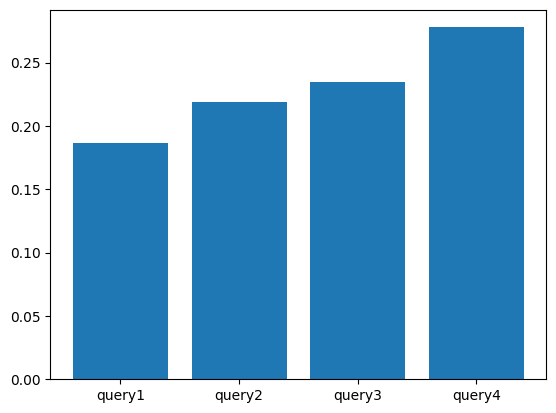

In [37]:
from matplotlib import pyplot as plt
plt.bar(smallDict.keys(), smallDict.values())

<h3>Dataset with 500k records</h3>

<h4>Query1</h4>

In [48]:
medium_sql1 = 'SELECT DISTINCT firstName AS name, lastName AS surname FROM mediumDB AS S WHERE courseID = 192'
cursor.execute(medium_sql1)
medium_query1 = cursor.fetchall()

In [49]:
for name, surname in medium_query1:
    print(name, surname)

Custodia Hidalgo
Sarah Lara
Narciso Ferrán
Patrícia Leite
Vigilija Gaižauskas
Casandra Arenas
Ledün Soylu
Arthur Laroche
Ana Narušis
Nath Nicolas
Émile Nicolas
Cathrine Lie
Ingeborg Amundsen
Nedas Naujokas
Christl Henschel
Miguel Real
Karl Christensen
Joris Kavaliauskas
Yuvaan Dara
Débora Vaz


<h4>Query2</h4>

In [50]:
medium_sql2 = 'SELECT DISTINCT courseName AS name FROM mediumDB WHERE discipline = \'statistics\' AND courseYear = 2022'
cursor.execute(medium_sql2)
medium_query2 = cursor.fetchall()

In [51]:
for course in medium_query2:
    print(course[0])

Econometrics: Methods and Applications
Exploratory Data Analysis
Understanding Clinical Research: Behind the Statistics
Introduction to Probability and Data with R
Bayesian Statistics: From Concept to Data Analysis
Introduction to Statistics
Python and Statistics for Financial Analysis
Basic Statistics
Foundations: Data, Data, Everywhere


<h4>Query3</h4>

In [52]:
medium_sql3 = 'SELECT COUNT(materialID) FROM mediumDB WHERE materialType = \'lecture slides\' AND discipline = \'maths\' AND email LIKE \'%gmail.com\''
cursor.execute(medium_sql3)
medium_query3 = cursor.fetchall()

In [53]:
for count in medium_query3[0]:
    print(count)

1698


<h4>Query4</h4>

In [54]:
medium_sql4 = 'SELECT DISTINCT firstName AS name, lastName as surname, country FROM mediumDB WHERE discipline = \'psychology\' AND country LIKE \'%orea\' AND dateOfBirth LIKE \'1%\' AND courseYear = 2023 ORDER BY surname ASC;'
cursor.execute(medium_sql4)
medium_query4 = cursor.fetchall()

In [56]:
for name, surname, country in medium_query4:
    print(name, surname, 'from', country)

Ninthe Horrocks from Noord-Korea
Cathrine Lie from South Korea
Miguel Real from República de Corea
Lynda Reynolds from Korea
Raghav Sura from North Korea


<h3>Execution times</h3>

In [58]:
cursor.execute(sql_get_profile)
profiles = cursor.fetchall()
for profile in profiles[(len(profiles) - 4) : len(profiles)]:
    print('The execution time of the \'%s\' query was: %f seconds' % (profile[2], profile[1]))

The execution time of the 'SELECT DISTINCT firstName AS name, lastName AS surname FROM mediumDB AS S WHERE courseID = 192' query was: 12.350354 seconds
The execution time of the 'SELECT DISTINCT courseName AS name FROM mediumDB WHERE discipline = 'statistics' AND courseYear = 2022' query was: 0.451687 seconds
The execution time of the 'SELECT COUNT(materialID) FROM mediumDB WHERE materialType = 'lecture slides' AND discipline = 'maths' AND email LIKE '%gmail.com'' query was: 0.519910 seconds
The execution time of the 'SELECT DISTINCT firstName AS name, lastName as surname, country FROM mediumDB WHERE discipline = 'psychology' AND country LIKE '%orea' AND dateOfBirth LIKE '1%' AND courseYear = 2023 ORDER BY surname ASC' query was: 0.538541 seconds


In [61]:
mediumList = list()
for profile in profiles[(len(profiles) - 4) : len(profiles)]:
    mediumList.append(profile[1])

In [62]:
mediumDict = {'query1' : None, 'query2' : None, 'query3' : None, 'query4' : None}
for i in range(0, 4):
    mediumDict['query' + str(i + 1)] = mediumList[i]

In [63]:
mediumDict

{'query1': 12.350354,
 'query2': 0.451687,
 'query3': 0.51991025,
 'query4': 0.53854075}

<BarContainer object of 4 artists>

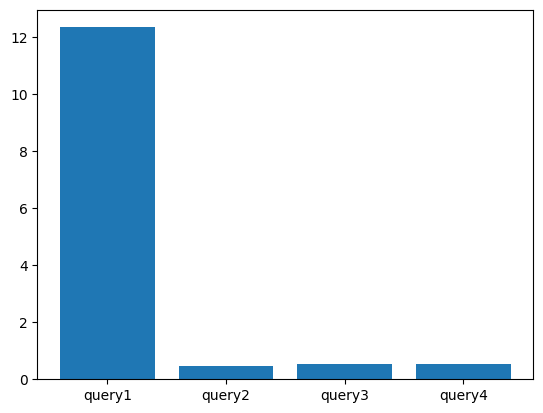

In [64]:
plt.bar(mediumDict.keys(), mediumDict.values())

<h3>Dataset with 750k records</h3>

<h4>Query1</h4>

In [74]:
large_sql1 = 'SELECT DISTINCT firstName AS name, lastName AS surname FROM largeDB AS S WHERE courseID = 192'
cursor.execute(large_sql1)
large_query1 = cursor.fetchall()

In [75]:
for name, surname in large_query1:
    print(name, surname)

Custodia Hidalgo
Sarah Lara
Narciso Ferrán
Patrícia Leite
Vigilija Gaižauskas
Casandra Arenas
Ledün Soylu
Arthur Laroche
Ana Narušis
Nath Nicolas
Émile Nicolas
Cathrine Lie
Ingeborg Amundsen
Nedas Naujokas
Christl Henschel
Miguel Real
Karl Christensen
Joris Kavaliauskas
Yuvaan Dara
Débora Vaz
Urvi Dani
Collin Heerkens
Brian Thompson
Özkutlu Gül
Dorita Abella
Liliana Flaiano


<h4>Query2</h4>

In [76]:
large_sql2 = 'SELECT DISTINCT courseName AS name FROM largeDB WHERE discipline = \'statistics\' AND courseYear = 2022'
cursor.execute(large_sql2)
large_query2 = cursor.fetchall()

In [77]:
for course in large_query2:
    print(course[0])

Econometrics: Methods and Applications
Exploratory Data Analysis
Understanding Clinical Research: Behind the Statistics
Introduction to Probability and Data with R
Bayesian Statistics: From Concept to Data Analysis
Introduction to Statistics
Python and Statistics for Financial Analysis
Basic Statistics
Foundations: Data, Data, Everywhere


<h4>Query3</h4>

In [78]:
large_sql3 = 'SELECT COUNT(materialID) FROM largeDB WHERE materialType = \'lecture slides\' AND discipline = \'maths\' AND email LIKE \'%gmail.com\''
cursor.execute(large_sql3)
large_query3 = cursor.fetchall()

In [79]:
for count in large_query3[0]:
    print(count)

2628


<h4>Query4</h4>

In [80]:
large_sql4 = 'SELECT DISTINCT firstName AS name, lastName as surname, country FROM largeDB WHERE discipline = \'psychology\' AND country LIKE \'%orea\' AND dateOfBirth LIKE \'1%\' AND courseYear = 2023 ORDER BY surname ASC;'
cursor.execute(large_sql4)
large_query4 = cursor.fetchall()

In [82]:
for name, surname, country in large_query4:
    print(name, surname, 'from', country)

Tere Castells from República Popular Democrática de Corea
Ninthe Horrocks from Noord-Korea
Cathrine Lie from South Korea
Miguel Real from República de Corea
Lynda Reynolds from Korea
Raghav Sura from North Korea


<h3>Execution times</h3>

In [83]:
cursor.execute(sql_get_profile)
profiles = cursor.fetchall()
for profile in profiles[(len(profiles) - 4) : len(profiles)]:
    print('The execution time of the \'%s\' query was: %f seconds' % (profile[2], profile[1]))

The execution time of the 'SELECT DISTINCT firstName AS name, lastName AS surname FROM largeDB AS S WHERE courseID = 192' query was: 16.317570 seconds
The execution time of the 'SELECT DISTINCT courseName AS name FROM largeDB WHERE discipline = 'statistics' AND courseYear = 2022' query was: 0.712044 seconds
The execution time of the 'SELECT COUNT(materialID) FROM largeDB WHERE materialType = 'lecture slides' AND discipline = 'maths' AND email LIKE '%gmail.com'' query was: 0.656846 seconds
The execution time of the 'SELECT DISTINCT firstName AS name, lastName as surname, country FROM largeDB WHERE discipline = 'psychology' AND country LIKE '%orea' AND dateOfBirth LIKE '1%' AND courseYear = 2023 ORDER BY surname ASC' query was: 0.819341 seconds


In [84]:
largeList = list()
for profile in profiles[(len(profiles) - 4) : len(profiles)]:
    largeList.append(profile[1])

In [85]:
largeDict = {'query1' : None, 'query2' : None, 'query3' : None, 'query4' : None}
for i in range(0, 4):
    largeDict['query' + str(i + 1)] = largeList[i]

In [86]:
largeDict

{'query1': 16.31756975,
 'query2': 0.7120445,
 'query3': 0.65684575,
 'query4': 0.8193405}

<BarContainer object of 4 artists>

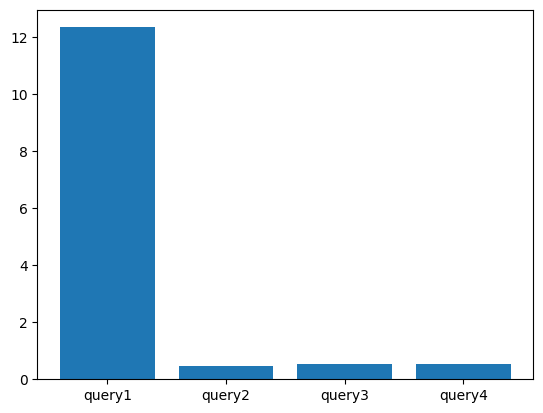

In [87]:
plt.bar(mediumDict.keys(), mediumDict.values())

<h3>Dataset with 1m records</h3>

<h4>Query1</h4>

In [88]:
humongous_sql1 = 'SELECT DISTINCT firstName AS name, lastName AS surname FROM humongousDB AS S WHERE courseID = 192'
cursor.execute(humongous_sql1)
humongous_query1 = cursor.fetchall()

In [89]:
for name, surname in humongous_query1:
    print(name, surname)

Custodia Hidalgo
Sarah Lara
Narciso Ferrán
Patrícia Leite
Vigilija Gaižauskas
Casandra Arenas
Ledün Soylu
Arthur Laroche
Ana Narušis
Nath Nicolas
Émile Nicolas
Cathrine Lie
Ingeborg Amundsen
Nedas Naujokas
Christl Henschel
Miguel Real
Karl Christensen
Joris Kavaliauskas
Yuvaan Dara
Débora Vaz
Urvi Dani
Collin Heerkens
Brian Thompson
Özkutlu Gül
Dorita Abella
Liliana Flaiano
Finn Karlsen
David Miranda
Torsten Schulz
Kristen Webb
Shaan Raju
Giuseppina Scarfoglio
Mamen Teruel
Eduardo Rezende
Melania Savorgnan


<h4>Query2</h4>

In [90]:
humongous_sql2 = 'SELECT DISTINCT courseName AS name FROM humongousDB WHERE discipline = \'statistics\' AND courseYear = 2022'
cursor.execute(humongous_sql2)
humongous_query2 = cursor.fetchall()

In [91]:
for course in large_query2:
    print(course[0])

Econometrics: Methods and Applications
Exploratory Data Analysis
Understanding Clinical Research: Behind the Statistics
Introduction to Probability and Data with R
Bayesian Statistics: From Concept to Data Analysis
Introduction to Statistics
Python and Statistics for Financial Analysis
Basic Statistics
Foundations: Data, Data, Everywhere


<h4>Query3</h4>

In [92]:
humongous_sql3 = 'SELECT COUNT(materialID) FROM humongousDB WHERE materialType = \'lecture slides\' AND discipline = \'maths\' AND email LIKE \'%gmail.com\''
cursor.execute(humongous_sql3)
humongous_query3 = cursor.fetchall()

In [93]:
for count in humongous_query3[0]:
    print(count)

3498


<h4>Query4</h4>

In [94]:
humongous_sql4 = 'SELECT DISTINCT firstName AS name, lastName as surname, country FROM humongousDB WHERE discipline = \'psychology\' AND country LIKE \'%orea\' AND dateOfBirth LIKE \'1%\' AND courseYear = 2023 ORDER BY surname ASC;'
cursor.execute(humongous_sql4)
humongous_query4 = cursor.fetchall()

In [95]:
for name, surname, country in humongous_query4:
    print(name, surname, 'from', country)

Tere Castells from República Popular Democrática de Corea
Leila Gailys from Korea
Ninthe Horrocks from Noord-Korea
Cathrine Lie from South Korea
Miguel Real from República de Corea
Lynda Reynolds from Korea
Raghav Sura from North Korea


<h3>Execution times</h3>

In [96]:
cursor.execute(sql_get_profile)
profiles = cursor.fetchall()
for profile in profiles[(len(profiles) - 4) : len(profiles)]:
    print('The execution time of the \'%s\' query was: %f seconds' % (profile[2], profile[1]))

The execution time of the 'SELECT DISTINCT firstName AS name, lastName AS surname FROM humongousDB AS S WHERE courseID = 192' query was: 5.392757 seconds
The execution time of the 'SELECT DISTINCT courseName AS name FROM humongousDB WHERE discipline = 'statistics' AND courseYear = 2022' query was: 0.789662 seconds
The execution time of the 'SELECT COUNT(materialID) FROM humongousDB WHERE materialType = 'lecture slides' AND discipline = 'maths' AND email LIKE '%gmail.com'' query was: 1.296368 seconds
The execution time of the 'SELECT DISTINCT firstName AS name, lastName as surname, country FROM humongousDB WHERE discipline = 'psychology' AND country LIKE '%orea' AND dateOfBirth LIKE '1%' AND courseYear = 2023 ORDER BY surname ASC' query was: 1.219439 seconds


In [97]:
humongousList = list()
for profile in profiles[(len(profiles) - 4) : len(profiles)]:
    humongousList.append(profile[1])

In [98]:
humongousDict = {'query1' : None, 'query2' : None, 'query3' : None, 'query4' : None}
for i in range(0, 4):
    humongousDict['query' + str(i + 1)] = humongousList[i]

In [99]:
humongousDict

{'query1': 5.392757,
 'query2': 0.789662,
 'query3': 1.296368,
 'query4': 1.2194385}

<BarContainer object of 4 artists>

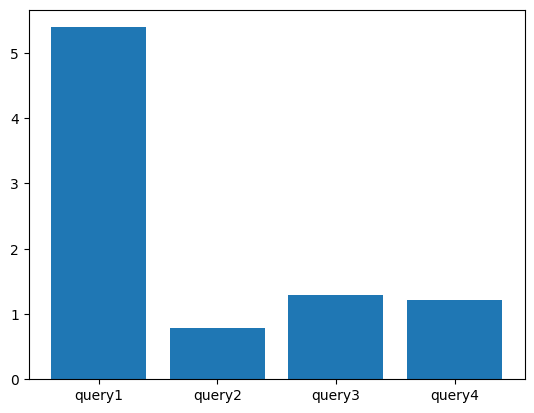

In [100]:
plt.bar(humongousDict.keys(), humongousDict.values())